# Demo of SF error analysis
*Semi-empirical approach to computing second-order statistics of gapped series*

Statistical moments of increments. 
$$D_p(\tau)=\langle | x(t+\tau)-x(t))^p | \rangle$$

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import utils as utils  # copied directly from Reynolds project, normalize() added
import sf_funcs as sf
import pickle

plt.rcParams.update({"font.size": 12})

# Set seed for reproducibility
np.random.seed(42)

## Load in the data
A magnetic field time series from PSP, already processed into Pandas DataFrame format

In [2]:
df_raw_full = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")
df_raw = df_raw_full["B_R"]
df_raw.head()

Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64

Optionally, check the data for missing data and its frequency, get summary stats

In [3]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))

### 0PTIONAL CODE END ###

510 missing points
Length of interval: 7522952
Duration of interval: 0 days 17:59:59.987519872
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = nan
Standard deviation = nan


## Standardise each interval 
to contain 8 correlation times `tc`. Start with *approximately* 15 correlation times across 75,000 points, then calculate correlation time and use this value to down-sample to 8 correlation times across 10,000 points.

In [4]:
tc_approx = 500  # s
tc_approx_n = 15
cadence_approx = 0.1  # s

tc_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tc_approx * tc_approx_n / cadence_approx)

In [5]:
# Original freq is 0.007s. Resampling to less rapid but still sufficiently high cadence, then splitting into chunks with ~15 correlation times

tc_approx = 500  # s
tc_approx_n = 15
cadence_approx = 0.1  # s

tc_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tc_approx * tc_approx_n / cadence_approx)

# We have approximately 15 correlation times in 10,000 points. Let's now be more precise, and calculate the correlation time from each chunk

# Split df into subsets
interval_list_approx = [
    df[i : i + interval_length_approx]
    for i in range(0, len(df) - interval_length_approx + 1, int(interval_length_approx))
]

del df  # free up memory

tc_list = []

for interval_approx in interval_list_approx:
    time_lags_lr, r_vec_lr = utils.compute_nd_acf(
        [interval_approx],
        nlags=10000,
        plot=False,
    )

    tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

    if tc == -1:
        tc = 500
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce not found for this chunk, setting to 500s (default) -> cadence = {new_cadence}s"
        )

    else:
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tce across {interval_length} points)"
        )

    tc_list.append(tc)

    interval_approx_resampled = interval_approx.resample(
        str(new_cadence) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        int_norm = utils.normalize(interval)
        good_inputs_list.append(int_norm)

print(
    "\nNumber of standardised intervals: "
    + str(len(good_inputs_list))
    + "\n(may be more than one per original chunk for small cadences)"
)

tce calculated to be 472.44s -> cadence = 0.94s (for 8tce across 4000 points)
tce calculated to be 519.81s -> cadence = 1.04s (for 8tce across 4000 points)
tce calculated to be 724.28s -> cadence = 1.45s (for 8tce across 4000 points)
tce calculated to be 612.58s -> cadence = 1.23s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s
tce calculated to be 181.96s -> cadence = 0.36s (for 8tce across 4000 points)
tce calculated to be 860.62s -> cadence = 1.72s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s

Number of standardised intervals: 12
(may be more than one per original chunk for small cadences)


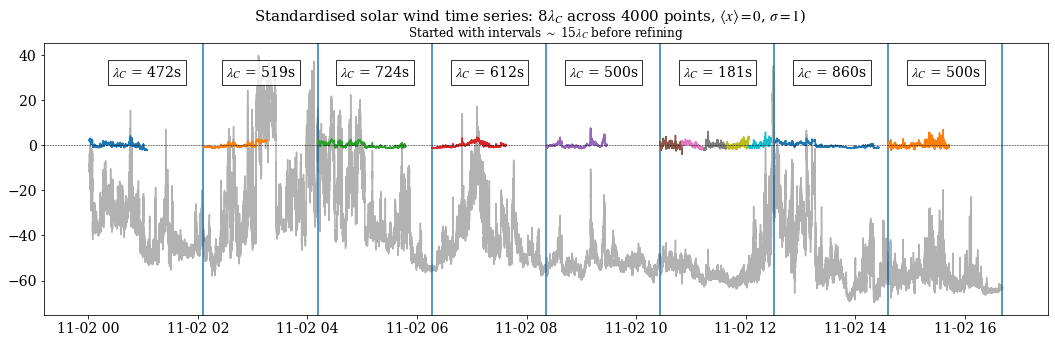

In [6]:
plt.rcParams.update({"font.size": 14})

fig, ax = plt.subplots(figsize=(18, 5))
[plt.plot(interval, alpha=0.3, c="black") for interval in interval_list_approx]
[plt.axvline(interval.index[-1]) for interval in interval_list_approx]
[plt.plot(interval) for interval in good_inputs_list]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
for index, tc in enumerate(tc_list):
    plt.text(
        x=interval_list_approx[index].index[0] + pd.Timedelta(seconds=1500),
        y=30,
        s=f"$\lambda_C$ = {int(tc)}s",
        bbox=dict(facecolor="white", alpha=0.8),
    )
plt.suptitle(
    f"Standardised solar wind time series: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$)",
    fontsize=15,
)
# Add subtitle
plt.title("Started with intervals $\sim$ 15$\lambda_C$ before refining", fontsize=12)

plt.savefig("plots/int_standardised_demo.png")
plt.rcParams.update({"font.size": 12})

Mostly, we can just fit one time series of 8tc into each original one of about 2 hours. (8tc is approx 80min).

In [7]:
for interval in good_inputs_list:
    print(len(interval))

4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000


## Get gapped statistics
Remove data from each input multiple times and compute SF, naive and interpolated

*Could use bin setting ability from heatmap to get binning of SF calculation*

In [8]:
# Subsetting for testing
good_inputs_list = good_inputs_list[:5]

In [9]:
# Logarithmically-spaced lags
# lags = np.unique(
#     np.logspace(0, np.log10(0.25 * len(good_inputs_list[0])), 10).astype(int)
# )
lags = np.arange(0, 0.25 * len(good_inputs_list[0]))

powers = [0.5, 2]
times_to_gap = 4

good_outputs_list = []
all_bad_inputs_list = []
all_bad_outputs_list = []
all_interp_inputs_list = []
all_interp_outputs_list = []

for i, input in enumerate(good_inputs_list):
    print("\nProcessing input {}".format(i))
    good_output = sf.compute_sf(pd.DataFrame(input), lags, powers)
    good_outputs_list.append(good_output)

    bad_inputs_list = []
    bad_outputs_list = []
    interp_inputs_list = []
    interp_outputs_list = []

    for total_removal in np.random.uniform(0, 0.9, times_to_gap):
        # Remove data (up to about 90%, may be some numerical issues with large %)
        # in both chunks and uniformly - split given by ratio_removal
        ratio_removal = np.random.uniform()
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )

        print(
            "Removed {0:.1f}% (approx. {1:.1f}% in chunks, {2:.1f}% uniformly)".format(
                prop_removed * 100, prop_remove_chunks * 100, prop_remove_unif * 100
            )
        )

        bad_inputs_list.append(bad_input.values)

        # Linearly interpolate the missing data
        interp_input = bad_input.interpolate(method="linear")
        interp_inputs_list.append(interp_input.values)

        bad_output = sf.compute_sf(pd.DataFrame(bad_input), lags, powers)
        bad_output["error"] = bad_output["sosf"] - good_output["sosf"]
        bad_output["error_percent"] = bad_output["error"] / good_output["sosf"] * 100
        bad_output["missing_prop_overall"] = prop_removed
        bad_output["lint"] = False
        bad_outputs_list.append(bad_output)

        interp_output = sf.compute_sf(pd.DataFrame(interp_input), lags, powers)
        interp_output["error"] = interp_output["sosf"] - good_output["sosf"]
        interp_output["error_percent"] = (
            interp_output["error"] / good_output["sosf"] * 100
        )
        interp_output["missing_prop_overall"] = prop_removed
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["sosf_se"] = bad_output["sosf_se"]
        # NOTE: Seems sensible uncertainty is the same for both
        interp_output["lint"] = True
        interp_outputs_list.append(interp_output)

    all_bad_inputs_list.append(bad_inputs_list)
    all_bad_outputs_list.append(bad_outputs_list)
    all_interp_inputs_list.append(interp_inputs_list)
    all_interp_outputs_list.append(interp_outputs_list)

# converting from pd.Series to list of np.arrays to save space
all_good_inputs_list = [interval.values for interval in good_inputs_list]


Processing input 0


Removed 32.4% (approx. 5.3% in chunks, 28.4% uniformly)
Removed 65.4% (approx. 37.4% in chunks, 48.2% uniformly)
Removed 58.4% (approx. 49.5% in chunks, 16.4% uniformly)
Removed 39.9% (approx. 45.8% in chunks, 8.1% uniformly)

Processing input 1
Removed 52.2% (approx. 41.7% in chunks, 25.3% uniformly)
Removed 51.2% (approx. 72.4% in chunks, 2.7% uniformly)
Removed 30.9% (approx. 2.9% in chunks, 28.8% uniformly)
Removed 5.5% (approx. 3.2% in chunks, 2.5% uniformly)

Processing input 2
Removed 61.9% (approx. 80.0% in chunks, 7.7% uniformly)
Removed 1.2% (approx. 0.9% in chunks, 0.4% uniformly)
Removed 51.6% (approx. 68.5% in chunks, 18.0% uniformly)
Removed 70.1% (approx. 6.3% in chunks, 68.3% uniformly)

Processing input 3
Removed 13.5% (approx. 3.2% in chunks, 10.6% uniformly)
Removed 11.3% (approx. 1.6% in chunks, 9.9% uniformly)
Removed 39.7% (approx. 30.8% in chunks, 28.7% uniformly)
Removed 50.9% (approx. 37.3% in chunks, 21.6% uniformly)

Processing input 4
Removed 8.2% (approx. 6

In [10]:
with open("data/processed/sfs_psp_local.pkl", "wb") as f:
    pickle.dump(
        [
            good_inputs_list,
            good_outputs_list,
            all_bad_inputs_list,
            all_bad_outputs_list,
            all_interp_inputs_list,
            all_interp_outputs_list,
        ],
        f,
    )

 Crashed on the following attempts:

` Nominal total removal: 2.5%
Nominal ratio: 1.1%`

`Nominal total removal: 52.0%
Nominal ratio: 0.1%`

## UP TO HERE ON RĀPOI

---

## Check a sample of results, for a given source interval

In [2]:
# Read in pickle file data/processed/list_of_list_of_dfs.pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import utils as utils  # copied directly from Reynolds project, normalize() added
import sf_funcs as sf
import pickle
import importlib

importlib.reload(sf)

with open("data/processed/sfs_psp_core_0.pkl", "rb") as f:
    list_of_list_of_dfs = pickle.load(f)

# Unpack the list of list of dfs
(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
) = list_of_list_of_dfs

In [3]:
print(
    f"{len(all_interp_outputs_list[0])} versions of {len(all_interp_outputs_list)} outputs"
)

3 versions of 98 outputs


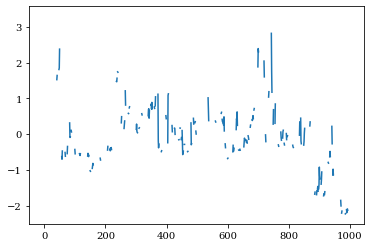

In [5]:
plt.plot(all_bad_inputs_list[0][2])

In [18]:
# Perform random train-test split
from sklearn.model_selection import train_test_split

(
    good_inputs_train,
    good_inputs_test,
    good_outputs_train,
    good_outputs_test,
    bad_inputs_train,
    bad_inputs_test,
    bad_outputs_train,
    bad_outputs_test,
    interp_inputs_train,
    interp_inputs_test,
    interp_outputs_train,
    interp_outputs_test,
) = train_test_split(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
    test_size=0.2,
    random_state=42,
)


### Naive

In [34]:
importlib.reload(sf)

<module 'sf_funcs' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\time_series_analysis\\sf_funcs.py'>

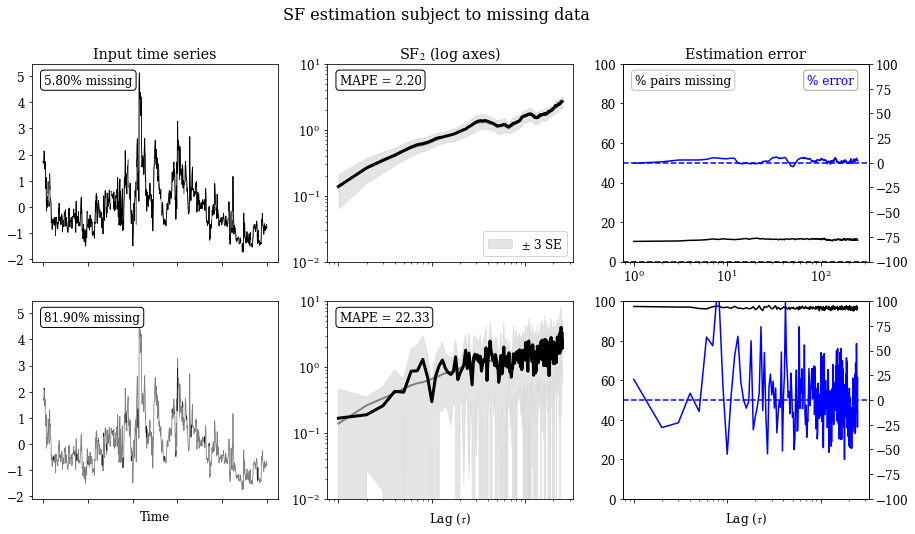

In [27]:
# Check results, for a given clean input

input_ind = 12
n = 2

sf.plot_sample(
    good_inputs_test,
    good_outputs_test,
    bad_inputs_test,
    bad_outputs_test,
    input_ind,
    n,
    False,
    "sosf",
)
# plt.savefig("plots_local/psp_missing_effect.png")

### Interpolated
NB: Error region for these results are taken from the SE for the naive calculations, reflecting the increased uncertainty of fewer *true* observations

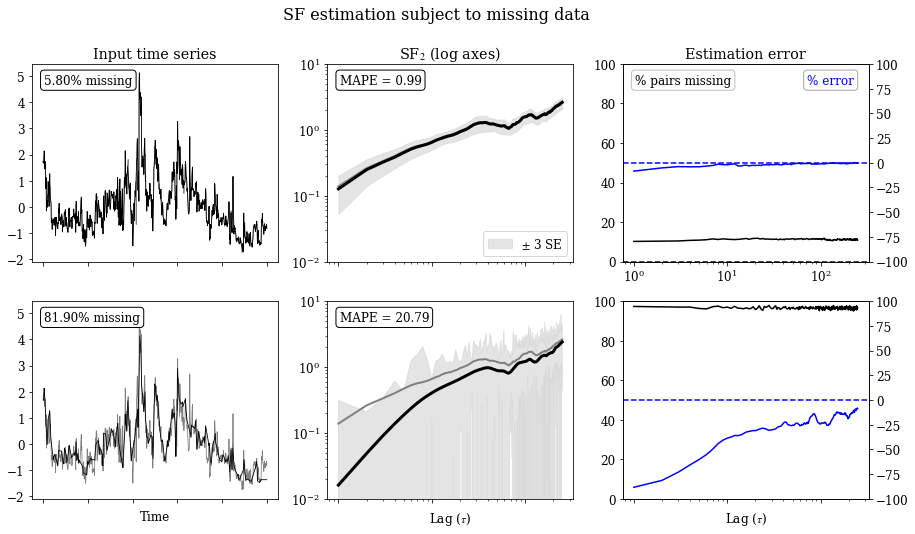

In [28]:
sf.plot_sample(
    good_inputs_test,
    good_outputs_test,
    interp_inputs_test,
    interp_outputs_test,
    input_ind,
    n,
    False,
    "sosf",
)
# plt.savefig("plots/psp_missing_effect_lint.png")

## Do holistic analysis of errors

In [39]:
# Concatenate the list of lists of dataframes to a single dataframe for error analysis
def concat_dfs(lst_of_list_of_dfs):
    merged_df = pd.concat(
        [pd.concat(lst, keys=range(len(lst))) for lst in lst_of_list_of_dfs],
        keys=range(len(lst_of_list_of_dfs)),
    )
    # Renaming MultiIndex levels
    merged_df.index.names = ["Original interval", "Interval version", "Lag"]
    return merged_df


bad_outputs_train_df = concat_dfs(bad_outputs_train)
interp_outputs_train_df = concat_dfs(interp_outputs_train)
bad_outputs_test_df = concat_dfs(bad_outputs_test)
interp_outputs_test_df = concat_dfs(interp_outputs_test)


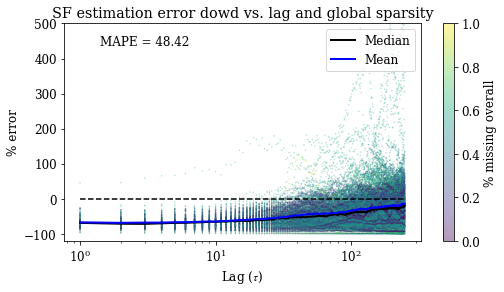

In [33]:
# View trends as fn of OVERALL missing amount
sf.plot_error_trend_line(bad_outputs_train_df, estimator="dowd")
# plt.savefig("plots/psp_missing_effect_holistic.png")

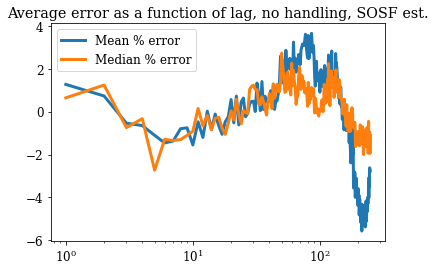

In [36]:
def plot_average_errors(df):
    stats = df.groupby("Lag")["sosf_error_percent"].describe()
    plt.plot(stats["mean"], lw=3, label="Mean % error")
    plt.plot(stats["50%"], lw=3, label="Median % error")
    plt.semilogx()
    plt.legend()
    plt.title("Average error as a function of lag, no handling, SOSF est.")


plot_average_errors(bad_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_avg.png")

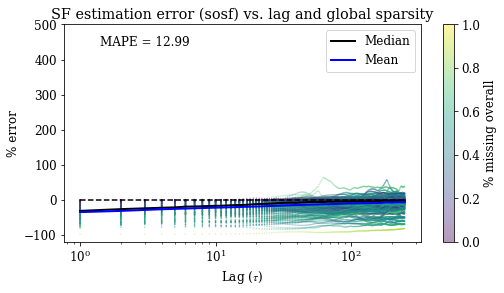

In [38]:
sf.plot_error_trend_line(interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_lint.png")

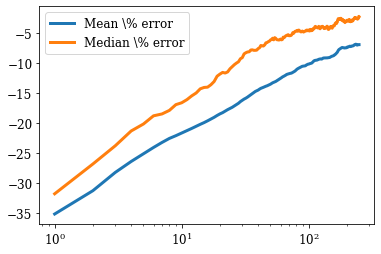

In [130]:
plot_average_errors(interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_lint_avg.png")

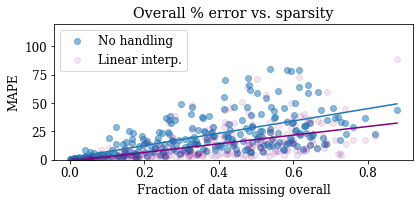

In [131]:
sf.plot_error_trend_scatter(bad_outputs_train_df, interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_scatter.png")

In [132]:
# Investigating weird spikes at small lag
interp_outputs_train_df.sort_values("sosf_error_percent", ascending=False).head(5)

n  0.5_mean   0.5_std  0.5_std_err  \
Original interval Interval version Lag                                          
63                2                63.0  936  0.671768  0.465869     0.015227   
                                   62.0  937  0.669329  0.469551     0.015340   
                                   64.0  935  0.674937  0.461008     0.015077   
                                   65.0  934  0.677946  0.455794     0.014914   
                                   66.0  933  0.680506  0.451171     0.014771   

                                          lag      sosf      mapd   sosf_se  \
Original interval Interval version Lag                                        
63                2                63.0  63.0  1.416853  0.302737  0.308970   
                                   62.0  62.0  1.431315  0.299952  0.543272   
                                   64.0  64.0  1.406121  0.314224  0.475965   
                                   65.0  65.0  1.398526  0.319202  0.369094   
                                   66.0  66.0  1.392484  0.319795  0.337804   

                                               ch      dowd  missing_prop  \
Original interval Interval version Lag                                      
63                2                63.0  0.445103  0.201447      0.907150   
                                   62.0  0.438674  0.197757      0.922175   
                                   64.0  0.453559  0.217023      0.920940   
                                   65.0  0.461702  0.223954      0.913369   
                                   66.0  0.468715  0.224787      0.912206   

                                         sosf_error  sosf_error_percent  \
Original interval Interval version Lag                                    
63                2                63.0    0.547965           63.065027   
                                   62.0    0.549006           62.223845   
                                   64.0    0.535201           61.452448   
                                   65.0    0.526321           60.343792   
                                   66.0    0.514802           58.654612   

                                         ch_error  ch_error_percent  \
Original interval Interval version Lag                                
63                2                63.0 -0.423785        -48.773284   
                                   62.0 -0.443635        -50.281152   
                                   64.0 -0.417360        -47.921803   
                                   65.0 -0.410503        -47.064966   
                                   66.0 -0.408968        -46.596295   

                                         dowd_error  dowd_error_percent  \
Original interval Interval version Lag                                    
63                2                63.0   -0.667442          -76.815599   
                                   62.0   -0.684552          -77.586400   
                                   64.0   -0.653897          -75.081154   
                                   65.0   -0.648250          -74.323173   
                                   66.0   -0.652896          -74.388576   

                                         missing_prop_overall  lint  
Original interval Interval version Lag                               
63                2                63.0                 0.707  True  
                                   62.0                 0.707  True  
                                   64.0                 0.707  True  
                                   65.0                 0.707  True  
                                   66.0                 0.707  True

## Create empirical correction factor

Here we work with the interpolated output errors, as they are more consistent that the no-handling errors (as evident in the error vs. lag and global sparsity plot), and with the *local* sparsity, as this gives us more information than the global sparsity.

In [41]:
missing_measure = "missing_prop"
n_bins = 15

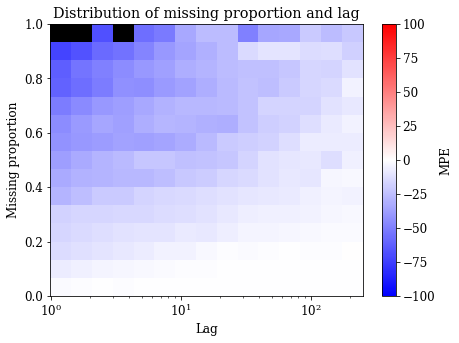

In [43]:
heatmap_bin_vals_log, heatmap_bin_edges_log, lookup_table_log = (
    sf.create_heatmap_lookup(interp_outputs_train_df, missing_measure, n_bins, log=True)
)

# If wanting linear bins, can then simply use the following:

# axs = sf.plot_heatmap(
#     heatmap_bin_vals,
#     heatmap_bin_edges,
#     "Missing proportion",
#     False,
# )

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_log[0],
    heatmap_bin_edges_log[1],
    heatmap_bin_vals_log.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")
ax.set_facecolor("black")
ax.set_xscale("log")
# plt.savefig(f"plots/psp_correction_heatmap_{n_bins}_bins.png")

Check out sample size in each bin (above just shows where there is no data with black bins).
Below 2D histogram is not working for log bins, for some reason

Text(0.5, 1.0, 'Distribution of missing proportion and lag')

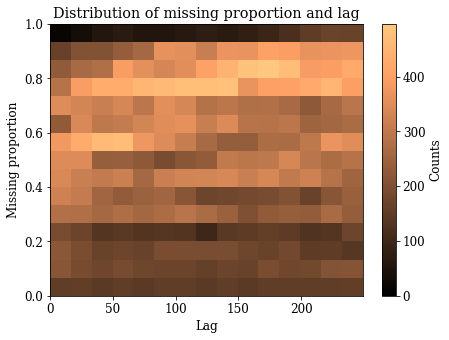

In [45]:
fig, ax = plt.subplots(figsize=(7, 5))
hb = ax.hist2d(
    interp_outputs_train_df["lag"],
    interp_outputs_train_df[missing_measure],
    bins=n_bins,
    cmap="copper",
    range=[[0, interp_outputs_train_df.lag.max()], [0, 1]],
)
plt.colorbar(hb[3], ax=ax, label="Counts")
hb[3].set_clim(0, hb[0].max())
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")
# plt.savefig("plots/psp_heatmap_sample_size.png")

In [46]:
# Compute heatmap of average error as fn of lag and missing prop at that lag
heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(interp_outputs_train_df, missing_measure, n_bins, True)
)

## Apply empirical correction factor to bad SFs

In [53]:
test_set_corrected = sf.compute_scaling(
    interp_outputs_test_df, missing_measure, lookup_table_log
)


More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
No nearest bin found for lag (4, 1, 1.0)! Scaling set to 1
No nearest bin found for lag (4, 1, 2.0)! Scaling set to 1
No nearest bin found for lag (4, 1, 4.0)! Scaling set to 1
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
No nearest bin found for lag (12, 0, 1.0)! Scaling set to 1
No nearest bin found for lag (12, 0, 2.0)! Scaling set to 1
No nearest bin found for lag (12, 0, 4.0)! Scaling set to 1
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
No nearest bin found for lag (17, 2, 1.0)! Scalin

In [54]:
test_set_corrected_3d = sf.compute_scaling_3d(
    interp_outputs_test_df, missing_measure, lookup_table_3d
)


More than one nearest bin found!
No nearest bin found for lag (2, 0, 4.0)! Scaling set to 1
More than one nearest bin found!
More than one nearest bin found!
More than one nearest bin found!
No nearest bin found for lag (3, 0, 11.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 12.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 13.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 43.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 44.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 45.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 46.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 47.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 48.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 49.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 50.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 51.0)! Scaling set to 1
No nearest bin found for lag (3, 0, 57.0)! Scaling set to 1
No nearest bin found for lag 

In [56]:
print(
    "Mean MAPE of interpolated intervals in test set = {:.2f}".format(
        interp_outputs_test_df["sosf_error_percent"].abs().mean()
    )
)

# Calculate corrected test set error
error_percents_2d = []
error_percents_3d = []
times_to_gap = 3

for i, df in enumerate(good_outputs_test):
    for j in range(times_to_gap):
        # Calculate difference
        error_2d = test_set_corrected.loc[(i, j), "sosf_corrected"] - df["sosf"]
        error_percent_2d = error_2d / df["sosf"] * 100
        error_percents_2d.append(error_percent_2d)

        error_3d = test_set_corrected_3d.loc[(i, j), "sosf_corrected_3d"] - df["sosf"]
        error_percent_3d = error_3d / df["sosf"] * 100
        error_percents_3d.append(error_percent_3d)

print(
    "Mean MAPE of corrected (2D) interpolated intervals test set = {:.2f}".format(
        np.mean(np.abs(error_percents_2d))
    )
)
print(
    "Mean MAPE of corrected (3D) interpolated intervals test set = {:.2f}".format(
        np.mean(np.abs(error_percents_3d))
    )
)


Mean MAPE of interpolated intervals in test set = 11.80
Mean MAPE of corrected (2D) interpolated intervals test set = 11.41
Mean MAPE of corrected (3D) interpolated intervals test set = 11.65


In [61]:
interp_outputs_test_df.loc[0, 1]["sosf_error_percent"].abs().mean()

2.8042855206561925

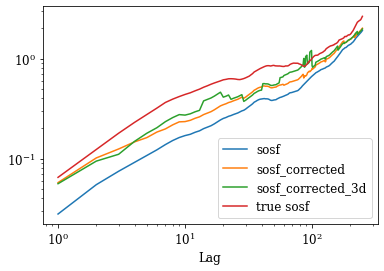

In [63]:
test_set_corrected.loc[0, 1][["sosf", "sosf_corrected", "sosf_corrected_3d"]].plot()
good_outputs_test[0]["sosf"].plot(label="true sosf")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

## Using the test set, plot the same intervals originally plotted

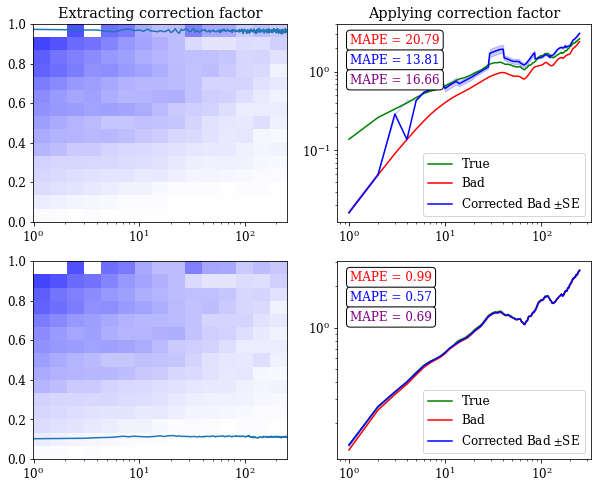

In [67]:
# Compute scaling factors for a given corrupted interval
# (ensure using interp factors for interp interval)

# Seems that smoothing does not help at this stage, perhaps given smoother heatmap to start with from larger sample size

fig, axs = plt.subplots(n, 2, figsize=(10, 4 * n))

for i in range(n):
    # print(f"\n2D: Correcting interval {i}:")
    # sf_corrected = sf.compute_scaling(
    #     all_interp_outputs_list[input_ind][i],
    #     missing_measure,
    #     lookup_table_log,
    # )
    # print(f"\n3D: Correcting interval {i}:")
    # sf_corrected_3d = sf.compute_scaling_3d(
    #     all_interp_outputs_list[input_ind][i],
    #     missing_measure,
    #     lookup_table_3d,
    # )

    # sf_corrected["error_corrected"] = (
    #     sf_corrected["sosf_corrected"] - good_outputs_list[input_ind]["sosf"]
    # )
    # sf_corrected["error_percent_corrected"] = (
    #     sf_corrected["error_corrected"] / good_outputs_list[input_ind]["sosf"] * 100
    # )
    mape_bad = (
        interp_outputs_test_df.loc[input_ind, i]["sosf_error_percent"].abs().mean()
    )
    mape_corrected = error_percents_2d[input_ind * times_to_gap + i].abs().mean()

    # sf_corrected_3d["error_corrected_3d"] = (
    #     sf_corrected_3d["sosf_corrected_3d"] - good_outputs_list[input_ind]["sosf"]
    # )
    # sf_corrected_3d["error_percent_corrected_3d"] = (
    #     sf_corrected_3d["error_corrected_3d"]
    #     / good_outputs_list[input_ind]["sosf"]
    #     * 100
    # )
    mape_corrected_3d = error_percents_3d[input_ind * times_to_gap + i].abs().mean()

    # # mape_corrected_sm = sf_corrected["error_percent_corrected_sm"].abs().mean()

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_bad),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.9),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="red",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.8),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="blue",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected_3d),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.7),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="purple",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].plot(good_outputs_test[input_ind]["sosf"], c="green", label="True")
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, i]["sosf"], c="red", label="Bad"
    )
    # axs[i, 1].plot(
    #     sf_corrected["sosf"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
    # )
    axs[i, 1].plot(
        test_set_corrected.loc[input_ind, i]["sosf_corrected"],
        c="blue",
        label="Corrected Bad $\pm$SE",
    )
    axs[i, 1].fill_between(
        test_set_corrected.loc[input_ind, i]["lag"],
        test_set_corrected.loc[input_ind, i]["sosf_corrected_lower"],
        test_set_corrected.loc[input_ind, i]["sosf_corrected_upper"],
        color="blue",
        alpha=0.2,
    )
    #    axs[i, 1].plot(
    #        sf_corrected["sosf_corrected_smoothed"],
    #        c="orange",
    #        label="Corrected Bad Smoothed",
    #    )
    # axs[i, 1].plot(
    #     sf_corrected_3d["sosf_corrected_3d"],
    #     c="purple",
    #     label="Corrected Bad (3D)",
    # )
    axs[i, 1].semilogx()
    axs[i, 1].semilogy()
    axs[i, 1].legend(loc="lower right")

    # if log is True:
    c = axs[i, 0].pcolormesh(
        heatmap_bin_edges_log[0],
        heatmap_bin_edges_log[1],
        heatmap_bin_vals_log.T,
        cmap="bwr",
    )
    # fig.colorbar(c, ax=axs[i, 0], label="MPE")
    c.set_clim(-100, 100)
    c.set_facecolor("black")
    # axs[i, 0].set_xlabel("Lag")
    axs[i, 0].plot(
        test_set_corrected.loc[input_ind, i]["lag"],
        test_set_corrected.loc[input_ind, i][missing_measure],
    )

    axs[0, 1].set_title("Applying correction factor")
    axs[0, 0].set_title("Extracting correction factor")
    axs[i, 0].set_xscale("log")

    # axs[i, 0] = sf.plot_heatmap(
    #     heatmap_bin_vals_log,
    #     heatmap_bin_edges_log,
    #     missing_measure=missing_measure,
    #     log=True,
    #     overlay_x=all_interp_outputs_list[input_ind][i]["lag"],
    #     overlay_y=all_interp_outputs_list[input_ind][i][missing_measure],
    #     subplot=axs[i, 0],
    # )

# plt.savefig(f"plots/psp_corrected_{n_bins}_bins.png")

## Plotting the 3D heatmap

In [68]:
plt.rcParams.update({"font.size": 8})

Text(0, 0.5, 'Missing proportion')

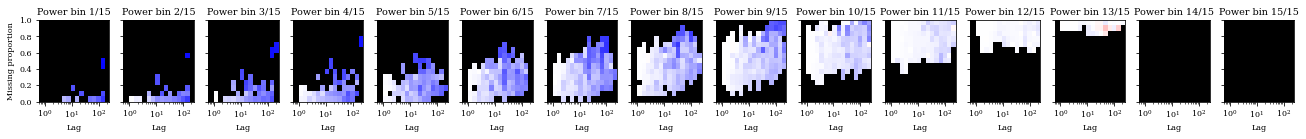

In [69]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag")
    ax[i].set_xlim(6e-1, 250)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
ax[0].set_ylabel("Missing proportion")
# plt.savefig("psp_heatmap_3d_power.png")


Text(0, 0.5, 'Power')

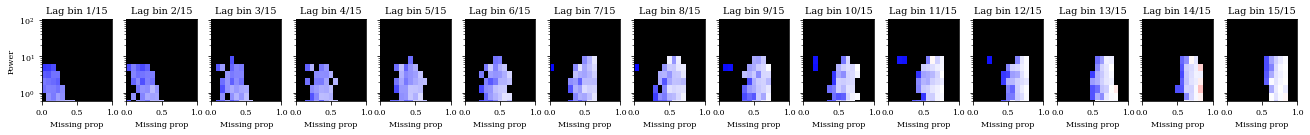

In [70]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Missing prop")
    # ax[i].set_xlim(6e-1, 250)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_ylim(6e-1, 105)
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
ax[0].set_ylabel("Power")
# plt.savefig("psp_heatmap_3d_lag.png")

Text(0, 0.5, 'Power')

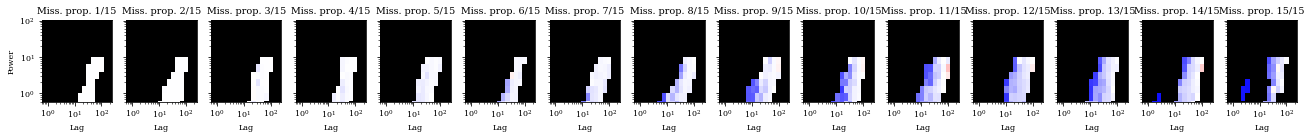

In [71]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlim(6e-1, 250)
    ax[i].set_ylim(6e-1, 105)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Miss. prop. {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
ax[0].set_ylabel("Power")
# plt.savefig("psp_heatmap_3d_missing.png")
